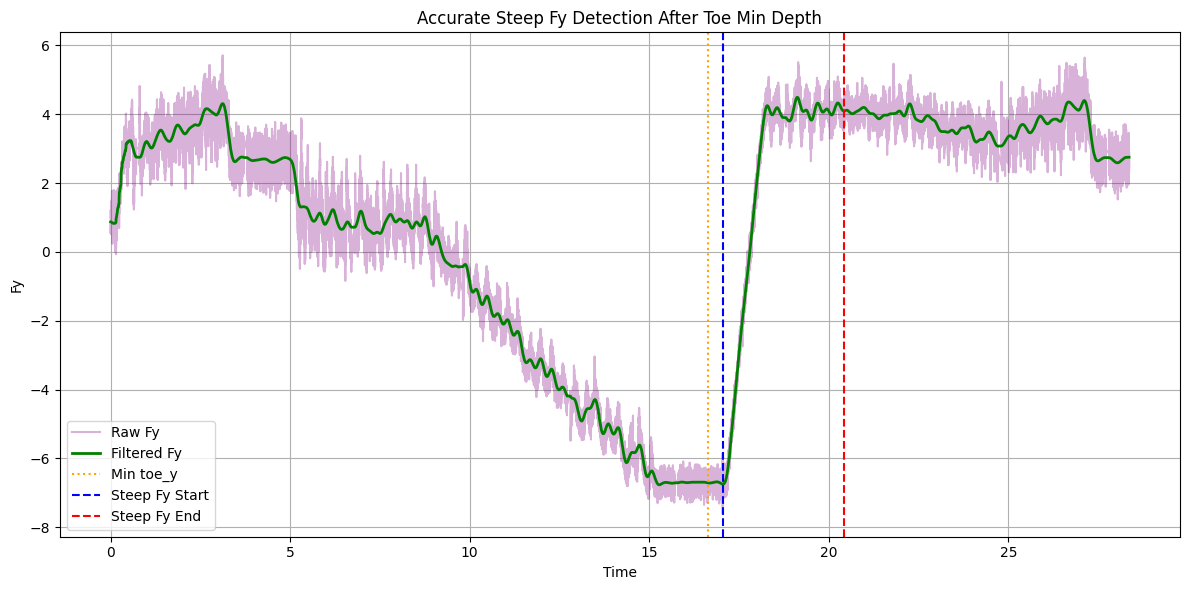

Minimum Toe Y @ 16.650 s (index 16123)
Steep Fy Rise Starts @ 17.070 s (index 16539)
Steep Fy Rise Ends @ 20.424 s (index 19804)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

file_path = r"C:\Users\Tarunika P\Downloads\LASSIE_DataForHeatMap\LASSIE_DataForHeatMap\plate0ex_angle0\plate0ex_angle0ex_len7_t1_Tue_Jun_10_14_37_07_2025.csv"
df = pd.read_csv(file_path, skiprows=2)

time_col = 'time'
fy_col = 'toeforce_y'
toe_y_col = 'toe_position_y'

def butter_lowpass_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

fs = 1 / np.mean(np.diff(df[time_col]))
df['Fy_filtered'] = butter_lowpass_filter(df[fy_col], cutoff=3.0, fs=fs)

df['dFy_dt'] = np.gradient(df['Fy_filtered'], df[time_col])

min_toe_idx = df[toe_y_col].idxmin()
min_toe_time = df[time_col].iloc[min_toe_idx]

rise_thresh = 1.0  # minimum dFy/dt to consider "steep"
window_check = 5   # require consistent slope for 5 samples
steep_start_idx = None

for i in range(min_toe_idx, len(df) - window_check):
    window = df['dFy_dt'].iloc[i:i+window_check]
    if np.all(window > rise_thresh):
        steep_start_idx = i
        break

if steep_start_idx is None:
    steep_start_idx = min_toe_idx  # fallback

flat_thresh = 0.2  # when dFy/dt becomes almost 0
flat_window = 10
steep_end_idx = None

for i in range(steep_start_idx + window_check, len(df) - flat_window):
    window = df['dFy_dt'].iloc[i:i+flat_window]
    if np.all(np.abs(window) < flat_thresh):
        steep_end_idx = i + flat_window
        break

steep_start_time = df[time_col].iloc[steep_start_idx]
steep_end_time = df[time_col].iloc[steep_end_idx] if steep_end_idx else None

plt.figure(figsize=(12, 6))
plt.plot(df[time_col], df[fy_col], label='Raw Fy', alpha=0.3, color='purple')
plt.plot(df[time_col], df['Fy_filtered'], label='Filtered Fy', color='green', linewidth=2)


plt.axvline(min_toe_time, color='orange', linestyle=':', label='Min toe_y')
plt.axvline(steep_start_time, color='blue', linestyle='--', label='Steep Fy Start')
if steep_end_idx:
    plt.axvline(steep_end_time, color='red', linestyle='--', label='Steep Fy End')

plt.title("Accurate Steep Fy Detection After Toe Min Depth")
plt.xlabel("Time")
plt.ylabel("Fy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Minimum Toe Y @ {min_toe_time:.3f} s (index {min_toe_idx})")
print(f"Steep Fy Rise Starts @ {steep_start_time:.3f} s (index {steep_start_idx})")
if steep_end_idx:
    print(f"Steep Fy Rise Ends @ {steep_end_time:.3f} s (index {steep_end_idx})")
else:
    print("Could not detect end of steep Fy rise.")


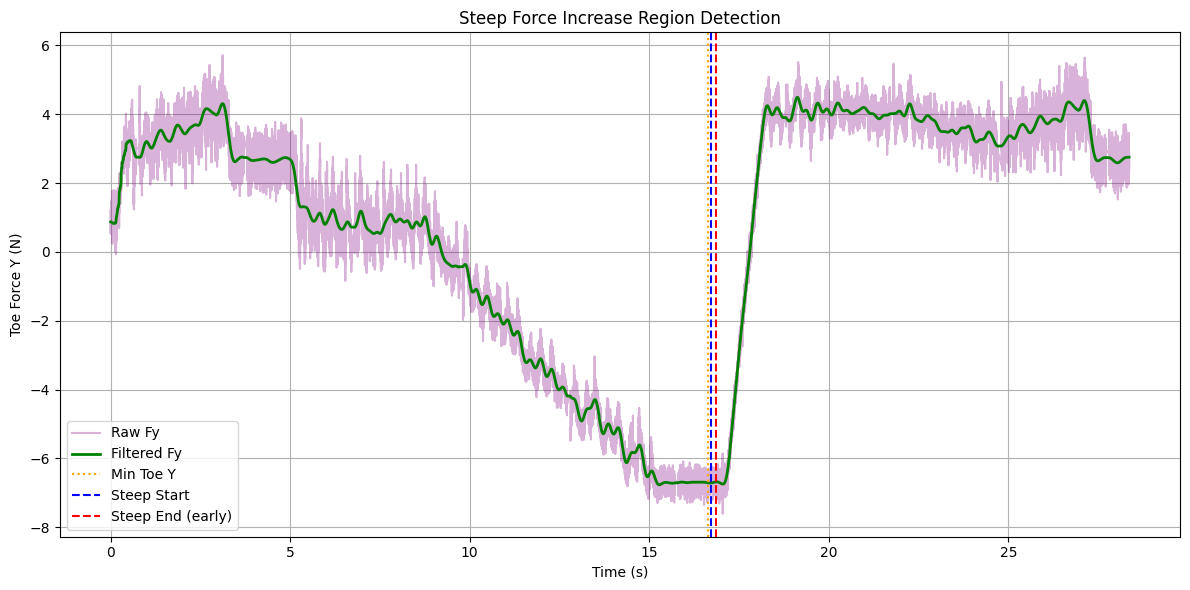

Toe Min Depth at: 16.650 s (index 16123)
Steep Force Rise Starts at: 16.720 s (index 16188)
Steep Force Rise Ends (Early Stop) at: 16.865 s (index 16337)
✅ Steep region removed: 16.72s to 16.87s


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

file_path = r"C:\Users\Tarunika P\Downloads\LASSIE_DataForHeatMap\LASSIE_DataForHeatMap\plate0ex_angle0\plate0ex_angle0ex_len7_t1_Tue_Jun_10_14_37_07_2025.csv"
df = pd.read_csv(file_path, skiprows=2)

time_col = 'time'
fy_col = 'toeforce_y'
toe_y_col = 'toe_position_y'

def butter_lowpass_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

fs = 1 / np.mean(np.diff(df[time_col]))
df['Fy_filtered'] = butter_lowpass_filter(df[fy_col], cutoff=3.0, fs=fs)

df['dFy_dt'] = np.gradient(df['Fy_filtered'], df[time_col])

start_idx = df[toe_y_col].idxmin()
start_time = df[time_col].iloc[start_idx]

rise_threshold = 1.0
steep_start_idx = None
for i in range(start_idx, len(df)):
    if df['dFy_dt'].iloc[i] > rise_threshold:
        steep_start_idx = i
        break
if steep_start_idx is None:
    steep_start_idx = start_idx

flatten_thresh = 0.3
stable_pts = 20
steep_end_idx = None
for i in range(steep_start_idx + 10, len(df) - stable_pts):
    window = df['dFy_dt'].iloc[i:i + stable_pts]
    if np.all(np.abs(window) < flatten_thresh):
        steep_end_idx = i + stable_pts - 10  # shift back 10 points as requested
        break

steep_start_time = df[time_col].iloc[steep_start_idx]
steep_end_time = df[time_col].iloc[steep_end_idx] if steep_end_idx else None

plt.figure(figsize=(12, 6))
plt.plot(df[time_col], df[fy_col], label='Raw Fy', color='purple', alpha=0.3)
plt.plot(df[time_col], df['Fy_filtered'], label='Filtered Fy', color='green', linewidth=2)

plt.axvline(start_time, color='orange', linestyle=':', label='Min Toe Y')
plt.axvline(steep_start_time, color='blue', linestyle='--', label='Steep Start')
if steep_end_idx:
    plt.axvline(steep_end_time, color='red', linestyle='--', label='Steep End (early)')

plt.title("Steep Force Increase Region Detection")
plt.xlabel("Time (s)")
plt.ylabel("Toe Force Y (N)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Toe Min Depth at: {start_time:.3f} s (index {start_idx})")
print(f"Steep Force Rise Starts at: {steep_start_time:.3f} s (index {steep_start_idx})")
if steep_end_idx:
    print(f"Steep Force Rise Ends (Early Stop) at: {steep_end_time:.3f} s (index {steep_end_idx})")
else:
    print(" Could not find end of steep force rise.")

if steep_end_idx:
    df_cleaned = pd.concat([df.iloc[:steep_start_idx], df.iloc[steep_end_idx:]], ignore_index=True)
    print(f"Steep region removed: {steep_start_time:.2f}s to {steep_end_time:.2f}s")
